## Marmousi Velocity Model

#### Table of Contents
<ul>
<li><a href="#lib">Necessary Libraries<a/></li>
<li><a href="#gpu">GPU Setting & Code Reproducibility<a/></li>
<li><a href="#model">Marmousi Velocity Model<a/></li>
<li><a href="#analytical">Reference Analytical Solution<a/></li>  
<li><a href="#test">Testing Data<a/></li>  
<li><a href="#train">Training Data<a/></li>
<li><a href="#sids">Source Location ID<a/></li>

<li><a href="#archi">Network Architecture & Parameter Initialisation<a/></li>
<li><a href="#tau">Neural Network<a/></li>
<li><a href="#pde">Eikonal PDE Loss<a/></li>
<li><a href="#other">Other Losses<a/></li>
<li><a href="#combine">Combined Loss Function<a/></li>
<li><a href="#new">Model Training<a/></li>
<li><a href="#t_pred">T Prediction<a/></li>
<li><a href="#accuracy">Rapid Accuracy Assessment<a/></li>

<a id="lib"></a>
#### Necessary Libraries

In [1]:
# Jax Libraries
import jax
import jax.numpy as jnp
from jax import grad, jit, random
import optax
import pickle
from jax.lib import xla_bridge

# Data Visualisation Libraries
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Operating System and gpu
import os 
import subprocess

# Additional 
import timeit
import pandas as pd

<a id="gpu"></a>
#### GPU Setting & Code Reproducibility

In [2]:
# Displays if the notebook currently has access to a gpu
print(f"This Notebook is currently running on a: {(xla_bridge.get_backend().platform)}")

# Assigns a specific GPU to be used
GPU = 1
os.environ['CUDA_VISIBLE_DEVICES'] = 'GPU'

# Displays the GPU details used for the notebook execution
output = subprocess.check_output(['nvidia-smi', '-L']).decode('utf-8')
gpu_info = output.strip().split('\n')
print(gpu_info[GPU])

# Defines a random key to be employed using seed 0
random_key = random.PRNGKey(0)

This Notebook is currently running on a: gpu
GPU 1: NVIDIA RTX A5000 (UUID: GPU-ee5cc10d-b7ab-8d6d-9149-28295c7820d0)


<a id="model"></a>
#### Marmousi Velocity Model

In [3]:
# Loading velocity model

filename="/home/archibong/Desktop/PINNs/Jax/Archibong1/PINNEik Using Jax/inputs/marm/model/marm_vz.txt"
marm = pd.read_csv(filename, index_col=None, header=None)
velmodel = jnp.reshape(jnp.array(marm), (101, 101)).T


In [4]:
#Model specifications

z_min = 0.; z_max = 2.; z_delta = 0.02;
x_min = 0.; x_max = 2.; x_delta = 0.02;


# Point-source location
sz = 1.0; sx = 1.0;

# Number of training points
training_points  = 3000

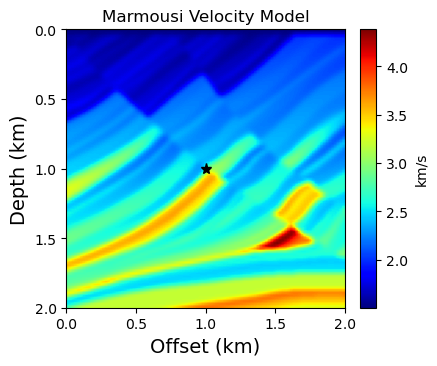

In [5]:

# Plot the velocity model with the source location

plt.style.use('default')

plt.figure(figsize=(4,4))

ax = plt.gca()
im = ax.imshow(velmodel, extent=[x_min,x_max,z_max,z_min], aspect=1, cmap="jet")

plt.title("Marmousi Velocity Model")    # Sets the title of the figure

ax.plot(sx,sz,'k*',markersize=8)

plt.xlabel('Offset (km)', fontsize=14)
plt.xticks(fontsize=10)

plt.ylabel('Depth (km)', fontsize=14)
plt.yticks(fontsize=10)

ax.xaxis.set_major_locator(plt.MultipleLocator(0.5))
ax.yaxis.set_major_locator(plt.MultipleLocator(0.5))

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="6%", pad=0.15)

cbar = plt.colorbar(im, cax=cax)

cbar.set_label('km/s',size=10)
cbar.ax.tick_params(labelsize=10)

plt.savefig("/home/archibong/Desktop/PINNs/Jax/Archibong1/PINNEik Using Jax/Images/Marmousi Velocity Model.pdf", format= "pdf",bbox_inches="tight")  # Saves the image as a pdf file at the specified file directory

plt.show()

<a id="analytical"></a>
#### Reference Analytical Solution

In [6]:
# Loading reference solution

filename="/home/archibong/Desktop/PINNs/Jax/Archibong1/PINNEik Using Jax/inputs/marm/traveltimes/fmm_or2_marm_s(1,1).txt"
T_data = pd.read_csv(filename, index_col=None, header=None)
T_data = jnp.reshape(jnp.array(T_data), (101, 101)).T

<a id="test"></a>
#### Testing Data

In [7]:
# Calculating refrence traveltimes for testing

z = jnp.arange(z_min,z_max+z_delta,z_delta)
nz = z.size

x = jnp.arange(x_min,x_max+x_delta,x_delta)
nx = x.size

Z,X = jnp.meshgrid(z,x,indexing='ij')

# Grid points for testing
X_star = [Z.reshape(-1,1), X.reshape(-1,1)]

In [8]:
# Analytical solution for the known traveltime part
vel = velmodel[int(round(sz/z_delta)),int(round(sx/x_delta))] # Velocity at the source location

T0 = jnp.sqrt((Z-sz)**2 + (X-sx)**2)/vel; 

px0 = jnp.where(T0 != 0, jnp.divide(X-sx, T0*vel**2), 0)  # Calculates the x-component of the vector 

pz0 = jnp.where(T0 != 0, jnp.divide(Z-sz, T0*vel**2), 0)  # Calculates the y-component of the vector 

#px0 = np.divide(X-sx, T0*vel**2, out=np.zeros_like(T0), where=T0!=0)
#pz0 = np.divide(Z-sz, T0*vel**2, out=np.zeros_like(T0), where=T0!=0)
     

<a id="train"></a>
#### Training Data

In [9]:
# Saves randomly selected points
selected_points = random.choice(random_key, jnp.arange(Z.size),shape=(training_points,),replace=False)

# Z and X Values for training
Zf = Z.reshape(-1,1)[selected_points]
Zf = jnp.append(Zf,sz)
Xf = X.reshape(-1,1)[selected_points]
Xf = jnp.append(Xf,sx)

# Grid point for training
X_starf = [Zf.reshape(-1,1), Xf.reshape(-1,1)]

In [10]:
# Appending source values
velmodelf = velmodel.reshape(-1,1)[selected_points]; velmodelf = jnp.append(velmodelf,vel)
px0f = px0.reshape(-1,1)[selected_points]; px0f = jnp.append(px0f,0.)
pz0f = pz0.reshape(-1,1)[selected_points]; pz0f = jnp.append(pz0f,0.)
T0f = T0.reshape(-1,1)[selected_points]; T0f = jnp.append(T0f,0.)

<a id="sids"></a>
#### Source Location ID

In [11]:
# Find source location id in X_star

TOLX = 1e-6
TOLZ = 1e-6

sids,_ = jnp.where(jnp.logical_and(jnp.abs(X_starf[0]-sz)<TOLZ , jnp.abs(X_starf[1]-sx)<TOLX))

print(sids)
print(sids.shape)
print(X_starf[0][sids,0])
print(X_starf[1][sids,0])

[3000]
(1,)
[1.]
[1.]


<a id="archi"></a>
#### Network Architecture & Parameter Initialisation

In [12]:
# Architecture of the neural network model
layers = [2,20,20,20,20,20,20,20,20,20,20,1]

> The random initialisation function using xavier initialisation has been defined below. However, this random initialisation is commented out and was not used to train the model for this script. The weights used to trained the model for this script are the learned weight from the smooth velocity model in script 1. This was done primarily to speedup the convergence of gradient descent and the function defined below was defined purely as an alternative 

In [13]:
"""
# Function to randomly initialise the network parameters using Xavier iniatialisation
def init_params(layers):

  keys = jax.random.split(jax.random.PRNGKey(0),len(layers)-1)
  params = list()      # Defines an empty list to store the parameters

  for key,n_in,n_out in zip(keys,layers[:-1],layers[1:]):   # For loop iterates over the keys, number of input neurons (n_in), and number of output neurons 
    lb = -(1 / jnp.sqrt(n_in)) # lower bound
    ub = (1 / jnp.sqrt(n_in)) # upper bound
    W = lb + (ub-lb) * jax.random.uniform(key,shape=(n_in,n_out))  # Initialises the weight matrix
    B = jax.random.uniform(key,shape=(n_out,))             # Initialises the bias vector 
    params.append({'W':W,'B':B})                           # Adds a dictionary containing the weight matrix W and bias vector B to the params list
  return params        # Returns the initialised parameters
"""

"\n# Function to randomly initialise the network parameters using Xavier iniatialisation\ndef init_params(layers):\n\n  keys = jax.random.split(jax.random.PRNGKey(0),len(layers)-1)\n  params = list()      # Defines an empty list to store the parameters\n\n  for key,n_in,n_out in zip(keys,layers[:-1],layers[1:]):   # For loop iterates over the keys, number of input neurons (n_in), and number of output neurons \n    lb = -(1 / jnp.sqrt(n_in)) # lower bound\n    ub = (1 / jnp.sqrt(n_in)) # upper bound\n    W = lb + (ub-lb) * jax.random.uniform(key,shape=(n_in,n_out))  # Initialises the weight matrix\n    B = jax.random.uniform(key,shape=(n_out,))             # Initialises the bias vector \n    params.append({'W':W,'B':B})                           # Adds a dictionary containing the weight matrix W and bias vector B to the params list\n  return params        # Returns the initialised parameters\n"

In [14]:
# Initialises the parameters of the neural network based on the specified layer architecture.
#params = init_params(layers)

In [15]:
with open('/home/archibong/Desktop/PINNs/Jax/Archibong1/PINNEik Using Jax/Model Weights/Jax_script_1_trained_weights.pkl', 'rb') as f:
    params = pickle.load(f)

<a id="tau"></a>
#### Neural Network

In [16]:
# Function tau to computes the output of the neural network 
def tau(params,zt,xt):

  X = jnp.concatenate([zt,xt],axis=1)

  *hidden,last = params
  for layer in hidden:

    X = jax.nn.tanh(X@layer['W']+layer['B']) # Applying the hyperbolic tangent (tanh) activation function

  return X@last['W'] + last['B'] 

<a id="pde"></a>
#### Eikonal PDE Loss

In [17]:
@jax.jit   # Just-in-Time (JIT) decorator to accelerate computation
def pde_loss(params,X_starf,T0t,px0t,pz0t,vt):
    
    # Reshapes all input parameters
    zt = X_starf[0].reshape(-1, 1)
    xt = X_starf[1].reshape(-1, 1)
    T0t = T0t.reshape(-1, 1)
    px0t = px0t.reshape(-1, 1)
    pz0t = pz0t.reshape(-1, 1)
    vt = vt.reshape(-1, 1)
    
    # Computes the output of the neural network
    tau_output = tau(params,zt,xt) 
    
    # Computes the gradient
    dtau_dz = jax.grad(lambda zt,xt: jnp.sum(tau(params, zt,xt)), argnums=0)(zt,xt)  # Gradient of the tau function with respect to zt
    dtau_dx = jax.grad(lambda zt,xt: jnp.sum(tau(params, zt,xt)), argnums=1)(zt,xt)  # # Gradient of the tau function with respect to xt

    # Computes the combined term
    term1 = T0t * dtau_dz + tau_output * pz0t
    term2 = T0t * dtau_dx + tau_output * px0t
    
    # Computes the PDE loss value using MSE function 
    loss_pde = 20*MSE(0,(jnp.square(term1) + jnp.square(term2) - 1.0 / (vt ** 2))) 
    
    return loss_pde

<a id="other"></a>
#### Other Losses

In [18]:
@jax.jit    # Just-in-Time (JIT) decorator to accelerate computation
def MSE(true_tau,pred_tau):
    # Function to compute mean squared error (MSE)
    
    return jnp.mean((true_tau-pred_tau)**2)  # Computes and returns the MSE between true and pred

In [19]:
@jax.jit   # Just-in-Time (JIT) decorator to accelerate computation
def tau_loss(params,X_starf):
    # Function to compute tau loss
    
    # # Reshapes all input parameters
    zt = X_starf[0].reshape(-1, 1)
    xt = X_starf[1].reshape(-1, 1)
    
    # Computes the output of the neural network
    tau_output = tau(params,zt,xt)  
    
    # Computes the tau loss value using MSE function
    tau_loss = MSE(jnp.ones(sids.shape), tau_output[sids])
    
    
    return tau_loss

<a id="combine"></a>
#### Combined Loss Function

In [20]:
@jax.jit    # Just-in-Time (JIT) decorator to accelerate computation
def loss_fun(params,X_starf, T0t, px0t, pz0t, vt):
    # Function to compute the combined loss from tau and PDE
    
    loss_tau = tau_loss(params,X_starf) # Obtains the tau loss value from tau loss function
    loss_pde = pde_loss(params,X_starf, T0t, px0t, pz0t, vt) # Obtains the PDE loss value from PDE loss function
    
    return loss_pde + loss_tau # Computes and returns the sum of the boths losses

<a id="new"></a>
#### Model Training

In [21]:
# defines an adaptive learning rate that changes at specified epochs
lr = optax.piecewise_constant_schedule(1e-4)#,{500:2.9e-3})

# Utilises the adam optimiser
optimizer = optax.adam(lr)

# Updates the parameters
opt_state = optimizer.init(params)

In [22]:
@jax.jit    # Just-in-Time (JIT) decorator to accelerate computation
def update(opt_state,params,X_starf, T0t, px0t, pz0t, vt):
    # Function to update the parameters for each gradient descent
    
    # calculates the gradients of loss_fun
    grads=jax.grad(loss_fun,0)(params,X_starf, T0t, px0t, pz0t, vt)

    # Update params
    updates, opt_state = optimizer.update(grads, opt_state)
    
    # Applies the updated params
    params = optax.apply_updates(params, updates)

    return opt_state,params

In [23]:
%%time
epochs = 120000 
loss_value = [] # List to hold the values of the combines loss
loss_pde = []   # List to hold the values of the PDE loss
loss_tau = []   # # List to hold the values of the tau loss

for epoch in range(epochs):  # For loop to iterate over the stipulates epochs
    opt_state, params = update(opt_state,params, X_starf,T0f, px0f, pz0f, velmodelf)

    # print loss and epoch info
    if epoch%(1000) ==0:
        loss_pp = loss_fun(params,X_starf,T0f, px0f, pz0f, velmodelf) # Computes the total loss
        loss_value.append(loss_pp)                                    # Appends the total loss value to the declared list
        print(f'Epoch = {epoch},\tloss = {loss_pp:.3e}')              # Prints the total loss values for each epoch

        #Individual losses
        loss_pde.append(pde_loss(params,X_starf, T0f, px0f, pz0f, velmodelf)) # Computes and appends the PDE loss
        loss_tau.append(tau_loss(params,X_starf))                       # Computes and appends the tau loss


Epoch = 0,	loss = 1.069e-01
Epoch = 1000,	loss = 1.895e-02
Epoch = 2000,	loss = 1.636e-02
Epoch = 3000,	loss = 1.349e-02
Epoch = 4000,	loss = 1.027e-02
Epoch = 5000,	loss = 8.489e-03
Epoch = 6000,	loss = 7.387e-03
Epoch = 7000,	loss = 6.359e-03
Epoch = 8000,	loss = 5.774e-03
Epoch = 9000,	loss = 5.269e-03
Epoch = 10000,	loss = 4.917e-03
Epoch = 11000,	loss = 4.702e-03
Epoch = 12000,	loss = 4.537e-03
Epoch = 13000,	loss = 4.368e-03
Epoch = 14000,	loss = 4.209e-03
Epoch = 15000,	loss = 4.068e-03
Epoch = 16000,	loss = 3.962e-03
Epoch = 17000,	loss = 3.873e-03
Epoch = 18000,	loss = 3.798e-03
Epoch = 19000,	loss = 3.728e-03
Epoch = 20000,	loss = 3.659e-03
Epoch = 21000,	loss = 3.595e-03
Epoch = 22000,	loss = 3.663e-03
Epoch = 23000,	loss = 3.522e-03
Epoch = 24000,	loss = 3.366e-03
Epoch = 25000,	loss = 3.287e-03
Epoch = 26000,	loss = 3.218e-03
Epoch = 27000,	loss = 3.164e-03
Epoch = 28000,	loss = 3.104e-03
Epoch = 29000,	loss = 3.065e-03
Epoch = 30000,	loss = 3.041e-03
Epoch = 31000,	loss =

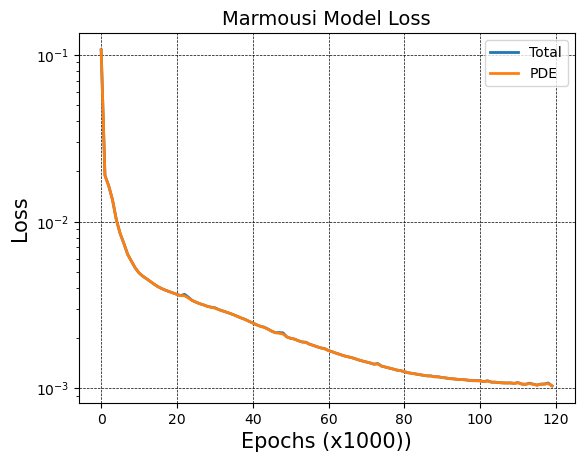

In [24]:
# Plotting the Loss Curve
plt.semilogy(loss_value, label="Total", linewidth=2) # Plots the total loss
plt.semilogy(loss_pde, label="PDE", linewidth=2)     # Plots the PDE loss
#plt.semilogy(loss_tau, label="tau", linewidth=2)    # Plots the tau loss

plt.title("Marmousi Model Loss", fontsize=14)   # Sets the title of the figure

plt.xlabel("Epochs (x1000))", fontsize=15)              # Sets the x-axis label of the figure
plt.ylabel("Loss", fontsize=15,)                # Sets the y-axis label of the figure

plt.grid(color = 'black', linestyle = '--', linewidth = 0.5) # Sets the grid of the figure

plt.legend(loc="upper right")   # Sets the legend of the figure

plt.savefig("/home/archibong/Desktop/PINNs/Jax/Archibong1/PINNEik Using Jax/Images/Marmousi Model Loss.pdf", format="pdf", bbox_inches="tight") # Saves the figure

plt.show() # Displays the figure

<a id="t_pred"></a>
#### T Prediction 

In [25]:
# Predicts tau output
tau_pred = tau(params,X_star[0].reshape(-1,1),X_star[1].reshape(-1,1))

# Computes T predicted using tau predicted
T_pred = tau_pred.reshape(Z.shape)*T0
T_pred.shape

(101, 101)

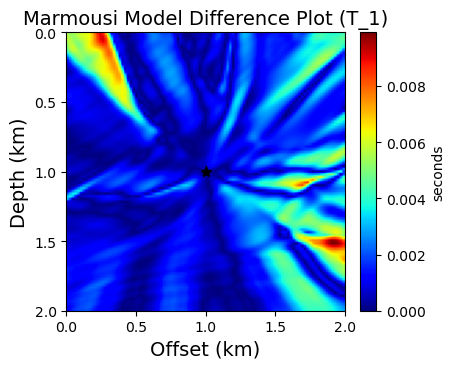

In [26]:
# T predicted and T analytical difference plot

plt.style.use('default')         # Sets the default style for the plot

plt.figure(figsize=(4,4))        # Creates a new figure with a size of 4x4 inches

plt.title("Marmousi Model Difference Plot (T_1)", fontsize=14)    # Sets the title of the figure

ax = plt.gca()                   # Gets the current axes instance

im = ax.imshow(jnp.abs(T_pred-T_data), extent=[x_min,x_max,z_max,z_min], aspect=1, cmap="jet")# Plots the velocity model velmodel as an image on the current axes (ax)

ax.plot(sx,sz,'k*',markersize=8) # Plots a black star marker at the source location 

plt.xlabel('Offset (km)', fontsize=14)     # Sets the label for the x-axis
plt.xticks(fontsize=10)          # Sets the font size for the x-axis tick labels

plt.ylabel('Depth (km)', fontsize=14)      # Sets the label for the y-axis
plt.yticks(fontsize=10)          # Sets the font size for the y-axis tick labels

ax.xaxis.set_major_locator(plt.MultipleLocator(0.5))   # Sets the major tick locator for the x-axis to have ticks at intervals of 0.5.
ax.yaxis.set_major_locator(plt.MultipleLocator(0.5))   # Sets the major tick locator for the y-axis to have ticks at intervals of 0.5.

divider = make_axes_locatable(ax)         # Creates a divider to make room for the colorbar
cax = divider.append_axes("right", size="6%", pad=0.15) # Appends an axes on the right side of the plot to accommodate the colorbar

cbar = plt.colorbar(im, cax=cax) # Adds a colorbar to the plot using the image im and the colorbar axes cax

cbar.set_label('seconds',size=10)   # Sets the label for the colorbar.
cbar.ax.tick_params(labelsize=10)        # Sets the font size of the colorbar tick labels.

plt.savefig("/home/archibong/Desktop/PINNs/Jax/Archibong1/PINNEik Using Jax/Images/Marmousi Model Difference Plot (T_1).pdf", format= "pdf",bbox_inches="tight")  # Saves the image as a pdf file at the specified file directory

plt.show()   # Displays the defined image

In [27]:
# Load fast sweeping traveltims for comparison

T_fsm = jnp.load('/home/archibong/Desktop/PINNs/Jax/Archibong1/PINNEik Using Jax/inputs/marm/traveltimes/Tcomp.npy')

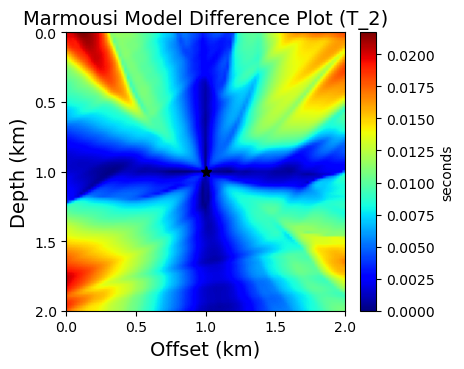

In [28]:
# T predicted and T Fast Sweeping difference plot

plt.style.use('default')         # Sets the default style for the plot

plt.figure(figsize=(4,4))        # Creates a new figure with a size of 4x4 inches

plt.title("Marmousi Model Difference Plot (T_2)", fontsize=14)    # Sets the title of the figure

ax = plt.gca()                   # Gets the current axes instance

im = ax.imshow(jnp.abs(T_fsm-T_data), extent=[x_min,x_max,z_max,z_min], aspect=1, cmap="jet")# Plots the velocity model velmodel as an image on the current axes (ax)

ax.plot(sx,sz,'k*',markersize=8) # Plots a black star marker at the source location 

plt.xlabel('Offset (km)', fontsize=14)     # Sets the label for the x-axis
plt.xticks(fontsize=10)          # Sets the font size for the x-axis tick labels

plt.ylabel('Depth (km)', fontsize=14)      # Sets the label for the y-axis
plt.yticks(fontsize=10)          # Sets the font size for the y-axis tick labels

ax.xaxis.set_major_locator(plt.MultipleLocator(0.5))   # Sets the major tick locator for the x-axis to have ticks at intervals of 0.5.
ax.yaxis.set_major_locator(plt.MultipleLocator(0.5))   # Sets the major tick locator for the y-axis to have ticks at intervals of 0.5.

divider = make_axes_locatable(ax)         # Creates a divider to make room for the colorbar
cax = divider.append_axes("right", size="6%", pad=0.15) # Appends an axes on the right side of the plot to accommodate the colorbar

cbar = plt.colorbar(im, cax=cax) # Adds a colorbar to the plot using the image im and the colorbar axes cax

cbar.set_label('seconds',size=10)   # Sets the label for the colorbar.
cbar.ax.tick_params(labelsize=10)        # Sets the font size of the colorbar tick labels.

plt.savefig("/home/archibong/Desktop/PINNs/Jax/Archibong1/PINNEik Using Jax/Images/Marmousi Model Difference Plot (T_2).pdf", format= "pdf",bbox_inches="tight")  # Saves the image as a pdf file at the specified file directory

plt.show()   # Displays the defined image

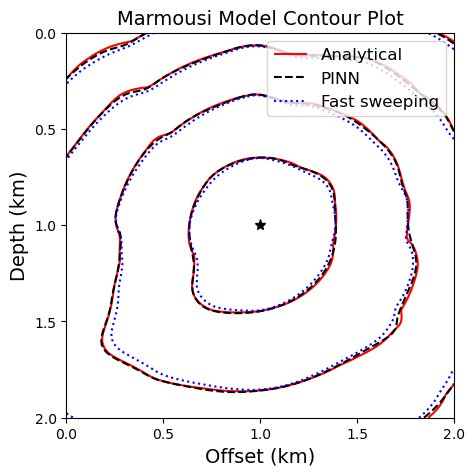

In [29]:
# Traveltime contour plots

plt.figure(figsize=(5,5)) # Creates a new figure with a size of 5x5 inches

ax = plt.gca()      # Gets the current axes instance

plt.title("Marmousi Model Contour Plot", fontsize=14)    # Sets the title of the figure

# Plots the contours of the difference T values as an image
im1 = ax.contour(T_data, 6, extent=[x_min,x_max,z_min,z_max], colors='r')
im2 = ax.contour(T_pred, 6, extent=[x_min,x_max,z_min,z_max], colors='k',linestyles = 'dashed')
im3 = ax.contour(T_fsm, 6, extent=[x_min,x_max,z_min,z_max], colors='b',linestyles = 'dotted')


ax.plot(sx,sz,'k*',markersize=8) # Plots a black star marker at the source location 

plt.xlabel('Offset (km)', fontsize=14)   # Sets the x-axis label
plt.ylabel('Depth (km)', fontsize=14)    # Sets the y-axis label

ax.tick_params(axis='both', which='major', labelsize=8)
plt.gca().invert_yaxis()

# Sets im1 legend
h1,_ = im1.legend_elements()
h2,_ = im2.legend_elements()
h3,_ = im3.legend_elements()

ax.legend([h1[0], h2[0], h3[0]], ['Analytical', 'PINN', 'Fast sweeping'],fontsize=12)  # Sets the combined legend

ax.xaxis.set_major_locator(plt.MultipleLocator(0.5))   # Sets the x-axis
ax.yaxis.set_major_locator(plt.MultipleLocator(0.5))   # Sets the y-axis

plt.xticks(fontsize=10)   # Sets the x-axis ticks
plt.yticks(fontsize=10)   # Sets the y-axis ticks

plt.savefig("/home/archibong/Desktop/PINNs/Jax/Archibong1/PINNEik Using Jax/Images/Marmousi Model Contour Plot.pdf", format="pdf", bbox_inches="tight")

plt.show()

<a id="training"></a>
#### Rapid Accuracy Assessment

In [30]:
print(jnp.linalg.norm(T_pred-T_data)/jnp.linalg.norm(T_data))
print(jnp.linalg.norm(T_pred-T_data))

0.0071622077
0.23677066
